<a href="https://colab.research.google.com/github/AHMEDHAMID123/Multilabels_per_iamge/blob/main/Multilabel_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multilable calssification 
- having more than one label per image
- Using PASCAL_2007 dataset
- The dataset has 15033 images
- The architucture used resnet 50

In [1]:
from fastai.vision.all import *

In [2]:
path = untar_data(URLs.PASCAL_2007)

In [3]:
path.ls()

(#8) [Path('/root/.fastai/data/pascal_2007/test.json'),Path('/root/.fastai/data/pascal_2007/test'),Path('/root/.fastai/data/pascal_2007/train.json'),Path('/root/.fastai/data/pascal_2007/segmentation'),Path('/root/.fastai/data/pascal_2007/train.csv'),Path('/root/.fastai/data/pascal_2007/train'),Path('/root/.fastai/data/pascal_2007/valid.json'),Path('/root/.fastai/data/pascal_2007/test.csv')]

In [4]:
import pandas as pd

## exploring the train data file

In [5]:
df = pd.read_csv(path/"train.csv")
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


## quick exploration for the data

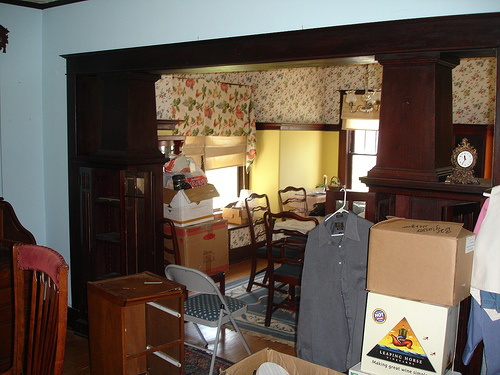

In [97]:
im = Image.open(path/"train"/df.fname[0])
im

The file names are saved in the fist column of the dataframe, will need a function to extract them. The labels are saved in the label column and are seperated by a space. is_valid column can be used to split the training data into train and validation sets.

### Building custome functions to get the labels, the variables and the do the split in the fastai DataBlok API

In [11]:
def get_x(x):
  return path/'train'/x["fname"]

In [12]:
def get_y(x):
  return x["labels"].split(" ")

In [17]:
def splitter(x):
  valid = x.index[x.is_valid == 1].tolist()
  train = x.index[~x.is_valid == 1].tolist()
  return train, valid

## Using fastai Datablock to construct the dataloaders

In [25]:

dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock), 
                   get_x = get_x, get_y = get_y, splitter = splitter, 
                   item_tfms= RandomResizedCrop(224, min_scale= .35))

In [26]:
dls = dblock.dataloaders(df)

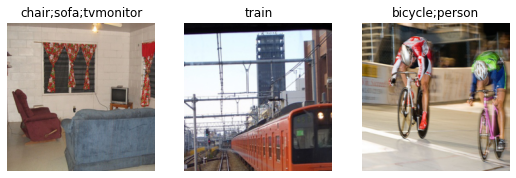

In [27]:
dls.show_batch(max_n= 3)

In [28]:
learn = vision_learner(dls , resnet50, metrics= accuracy_multi)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [30]:
learn.fine_tune(5, base_lr= 1e-3, freeze_epochs= 4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.788107,0.610928,0.681952,00:38
1,0.754923,0.557827,0.734303,00:38
2,0.682428,0.460532,0.819343,00:39
3,0.558211,0.283824,0.934442,00:38


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.343839,0.239554,0.951076,00:44
1,0.287945,0.163686,0.967092,00:44
2,0.230145,0.127652,0.970976,00:45
3,0.186931,0.112019,0.973168,00:44
4,0.161462,0.109535,0.973625,00:44


The model performance is acceptable considering the time of training and the number of epochs

# Using data augmnetation and learning rate finder

In [31]:

dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock), 
                   get_x = get_x, get_y = get_y, splitter = splitter, 
                   item_tfms= RandomResizedCrop(224, min_scale= .35), batch_tfms= aug_transforms(mult= 2))

In [32]:
dls = dblock.dataloaders(df)

In [79]:
learn = vision_learner(dls, resnet50, metrics= accuracy_multi)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


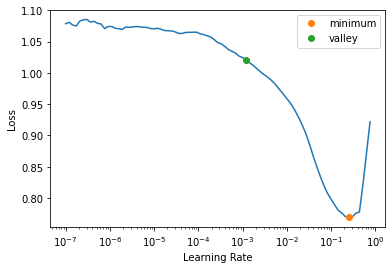

In [81]:
lr_min, lr_valley = learn.lr_find(suggest_funcs=(minimum, valley))

In [83]:
lr = lr_min/10

In [84]:
learn.fine_tune(5, base_lr= lr, freeze_epochs= 4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.931685,0.670247,0.648267,00:40
1,0.819875,0.556638,0.738765,00:37
2,0.638759,0.257219,0.939801,00:38
3,0.387676,0.100009,0.968008,00:38


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.129749,0.083593,0.972649,00:44
1,0.117106,0.088269,0.969144,00:44
2,0.103015,0.078733,0.971912,00:44
3,0.089173,0.074944,0.973506,00:44
4,0.079664,0.073287,0.974323,00:44


### Checking the effect of the threshold of the acuuracy_multi metric on the model perofrmance

In [85]:
preds, targets = learn.get_preds()

In [86]:
accuracy_multi(preds, targets, sigmoid= False)

TensorBase(0.9743)

In [87]:
x = np.linspace(0.05, 0.99, 30)
acc = np.array([accuracy_multi(preds, targets, thresh = i , sigmoid = False) for i in x ])

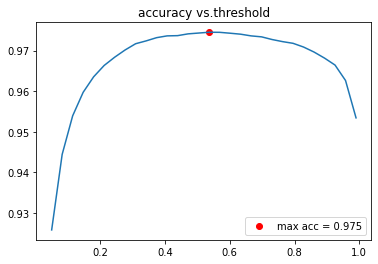

In [105]:
plt.plot(x, acc)
plt.scatter(x[np.argmax(acc)], acc.max(), color = "r", label = "max acc = {:.3f}".format(np.max(acc)))
plt.title("accuracy vs.threshold")
plt.legend();

The maximum accurecy achieved by changing the threshold from the default value 0.5 will not make any noticable difference. 

In [106]:
learn.export("multi_labels.pkl")